## Imaging Star Clusters Tutorial:

This is a tutorial to teach you how to make images of star clusters using data from FIRE 2 Simulations.

### Initial set up
Make sure you have downloaded all files from the github link: https://github.com/Amoac/star-cluster-imaging 

There is a variety of imports to make the code work so you may need to use pip install to successfully run the code. You will need to edit the sys.path.append to the location of your 'simulations_code' file.

Additional information about the functions in this code can be found in star_cluster_imaging.py

In [3]:
import sys
sys.path.append("/home1/09528/amoac/simulations_code/") 
import gizmo_analysis as gizmo 
import utilities as ut
from fof_analysis import fof
from fof_analysis import star_cluster_imaging
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from matplotlib import rc #to use Latex math symbols like 'phi'
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from astropy.table import Table
from astropy.io import ascii
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colorbar as colorbar
from importlib import reload
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

#simulation files path
simname     = 'm12i_res7100'
simdir      = '/scratch/07428/binod/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/'

If you make edits to any of the functions in the star_cluster_imaging package you will need to reload them with the function below:

In [2]:
reload(star_cluster_imaging) 

<module 'fof_analysis.star_cluster_imaging' from '/home1/09528/amoac/analysis/fof_analysis/star_cluster_imaging.py'>

### Getting Started
We will start set up by establishing some units to be used in future calculations and initializing dictionaries that will be used to contain the gas and star properties that we will use to produce images.

In [3]:
#establishing some units 
b_parsec    = 4
b_kpc       = b_parsec / 1000.
ncut_min    = 5
softening   = 4. #res 7100

# Initialize dictionaries to store properties
gas_star_properties_data = {}
part = {}

***Choosing Snapshots:*** you can choose any number of snapshots you like ranging from 576 to 696. 
Each snapshot takes ~3 minutes to load.

In [4]:
snaps = [694] #set snaps to an arrange of values, goes from 576 to 696
# Example with multiple snapshots: snaps = [693,694,695]

In [5]:
# This loop automatically stores snapshot data for any number of snapshots 
for snapshot in snaps:
    # Read the snapshot data for the current snapshot
    part[snapshot] = gizmo.io.Read.read_snapshots(['star', 'gas'],'index', snapshot, simulation_directory=simdir, assign_hosts_rotation=True,assign_hosts=True)
    # Get star properties for the current snapshot
    gas_star_properties_data[snapshot] = star_cluster_imaging.get_gas_star_properties(part[snapshot])


# in utilities.simulation.Snapshot():
* reading:  scratch/07428/binod/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/snapshot_times.txt

  using snapshot index = 694, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/07428/binod/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/output/snapdir_694/snapshot_694.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 55619432 particles
    star      (id = 4): 15373886 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star', 'gas']
  gas properties: ['acceleration', 'density', 'electron.fraction', 'hydrogen.neutral.fraction', 'id', 'id.child', 'id.generation', 'magnetic.field', 'mass', 'massfraction', 'photon.energy', 'position', 'potential', 'sfr', 'size', 'temperature', 'velocity']

* reading particles from:
    snapshot_694.0.hdf5
    snapshot_6

***Choosing your star cluster***: You can select which star cluster you would like to view after running the cell below once.

You can change the filter for age ranges of the stars by editing the value of age_cut_Myr_Max and age_cut_Min_Myr. This can reduce or increase the number of stars that will be imaged later on.

In [6]:
# Process the snapshots to get initial cluster information
cluster_select = 0 #change this to any cluster as long as it is within range of the 'number of groups' value after running first_snapshot_data, 0 being the first cluster 
first_snapshot_data = star_cluster_imaging.process_first_snapshot(gas_star_properties_data[snaps[0]],age_cut_Max_Myr=2, age_cut_Min_Myr=1, cluster_select = cluster_select )

linking length  0.004
min number particles in group  5
0.01997089385986328 seconds
number of groups 2
max number in a group 19


***Variables and lists to be initialized***

Editing pc_width changes how zoomed in you are to the cluster. Higher values zoom out more while smaller values zoom in.

In [7]:
# Initialize variables
pc_width = 40 # this changes the zoom of the image. Based on this value the total width of the picture will be 2*pc_width
kpc_width = pc_width / 1e3
num_snapshots = len(snaps)

# Create a list to store each snapshot's XY plane image data
xy_images = []
titles = []

### Imaging Making Your First Star Cluster Picture

***Editing the size of your plots:***

By changing the value of image_size_multiplier, you can make your plots bigger or smaller

In [8]:
plot_size = 5
fig = plt.figure(figsize=(num_snapshots*plot_size, plot_size))
gs0 = gridspec.GridSpec(1, num_snapshots+1, width_ratios= [1] * num_snapshots + [0.1])

<Figure size 500x500 with 0 Axes>

***Below you will learn how to create an image of a star cluster while viewed on the XY plane.***

These lines of code are preparing and organizing the star cluster data for the current snapshot. The goal is to accurately track the stars from the first snapshot across all subsequent snapshots, ensuring that the images generated reflect the proper evolution of the same group of stars over time. The preserve_ids function is particularly crucial as it maintains this continuity, which is essential for making meaningful comparisons between snapshots.

In [9]:
gs = gas_star_properties_data[snapshot]
   
s_loc = star_cluster_imaging.preserve_ids(
    first_snapshot_data['ids_cluster'],
    first_snapshot_data['id_generation_cluster'],
    first_snapshot_data['id_child_cluster'], 
    gs['ids'], 
    gs['id_generation'],
    gs['id_child'])

This part of the code is responsible for preparing and processing the data related to the star cluster and surrounding gas for the current snapshot. It identifies and organizes the relevant star and gas particles, applies smoothing to the gas data, and prepares the data for visualization. This ensures that the resulting images are accurate, clear, and focus on the key features of the star cluster’s evolution.

In [15]:
#editing vmin or vmax values will change how the gas appears on the plots
vmin_value = 2.5e2  # Minimum value for the color bar
vmax_value = 5e4    # Maximum value for the color bar

cluster_info = star_cluster_imaging.find_new_snap_info(s_loc, gs)

mass_cluster = cluster_info['mass_cluster']
x_cluster = cluster_info['x_cluster']
y_cluster = cluster_info['y_cluster']
z_cluster = cluster_info['z_cluster']
    

xcm1 = first_snapshot_data['sxcm'][cluster_select]
ycm1 = first_snapshot_data['sycm'][cluster_select]
zcm1 = first_snapshot_data['szcm'][cluster_select]


#creating filter that will only select the young stars that are visible in the picture
g_ind, s_ind = star_cluster_imaging.get_gas_star_indices(xcm1, ycm1, zcm1, gs, pc_width=pc_width)
    
gas_star_coordinates = star_cluster_imaging.gas_star_coordinates(gs, g_ind, x_cluster, y_cluster, z_cluster)

#Gaussian Smoothing for gas particles
vel_array_xy, res_xy, extent_xy = star_cluster_imaging.compute_velocity_array_xy(xcm1, ycm1, zcm1, gas_star_coordinates, pc_width=pc_width, stepn=13) # change the value of stepn to change the gas resolution
vel_array_xy = np.where(vel_array_xy < vmin_value, vmin_value, vel_array_xy) #This line is important for filling in any empty spaces in the gaussian smoothing. without it you end up with ugly white spaces when there is not gas in a region. 

***Display the image***

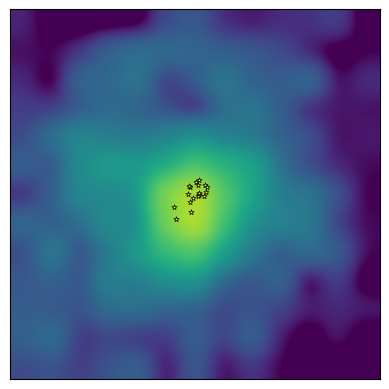

In [16]:
ax = plt.subplot(gs0[0])
ax.get_xaxis().set_visible(False) #remove x-axis labels
ax.get_yaxis().set_visible(False) #remove y-axis labels
ax.set_xlim(xcm1 - kpc_width, xcm1 + kpc_width) #keeping the image within kpc_width
ax.set_ylim(ycm1 - kpc_width, ycm1 + kpc_width) #keeping the image within kpc_width

#PLOT GAS 
ax.imshow(vel_array_xy.T / ((res_xy * 1000.) ** 2), interpolation='gaussian', norm=LogNorm(vmin=vmin_value, vmax=vmax_value), extent=extent_xy, origin='lower')

#PLOT STARS 
ax.scatter(x_cluster, y_cluster, s=15, marker='*', edgecolors='black', facecolors='yellow', linewidth=0.5) #This plots the stars, you can edit the colors and sizes to your liking

plt.show() #Display the image

***Final Touches***

We have finally created our picture! Lets add some labels and other helpful indicatiors.

Below demonstrates a few examples for lables you may use including a color bar, realistic times, a scale bar, or just plain text:

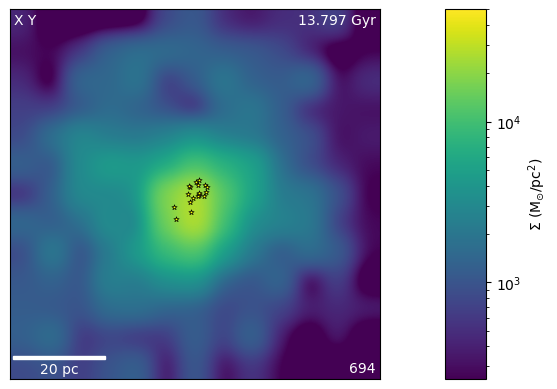

In [17]:
ax = plt.subplot(gs0[0])
ax.get_xaxis().set_visible(False) #remove x-axis labels
ax.get_yaxis().set_visible(False) #remove y-axis labels
ax.set_xlim(xcm1 - kpc_width, xcm1 + kpc_width) #keeping the image within kpc_width
ax.set_ylim(ycm1 - kpc_width, ycm1 + kpc_width) #keeping the image within kpc_width

#PLOT GAS 
ax.imshow(vel_array_xy.T / ((res_xy * 1000.) ** 2), interpolation='gaussian', norm=LogNorm(vmin=vmin_value, vmax=vmax_value), extent=extent_xy, origin='lower')

#PLOT STARS 
ax.scatter(x_cluster, y_cluster, s=15, marker='*', edgecolors='black', facecolors='yellow', linewidth=0.5) #This plots the stars, you can edit the colors and sizes to your liking

### Plain text
ax.text(0.01 ,0.99,'X Y', ha = 'left', va ='top', transform = ax.transAxes, c = 'white')
ax.text(0.99 ,0.01, snaps[0], ha = 'right', va ='bottom', transform = ax.transAxes, c = 'white')

### Making Time Labels
snapshot_times = simdir + '/snapshot_times.txt' # Reading in the snapshot times from a text file to create titles for the images
snapnumber = snaps[0]  
# Reading the snapshot times and associated data from the text file
snaptime_data = np.genfromtxt(snapshot_times, usecols=(0, 3), skip_header=4, dtype=float)
snaps1 = np.array(snaptime_data[:, 0]) # Extracting the snapshot numbers (first column) from the data
times = np.array(snaptime_data[:, 1]) # Extracting the corresponding times (fourth column) from the data
snaptime = times[np.where(snaps1 == snapnumber)][0]# Finding the time associated with the current snapshot number
titles.append(f'XY VIEW {snaptime:.3f} Gyr')# Creating a title string that includes the snapshot time for the XY view
title = f'{snaptime:.3f}' + ' Gyr'# Creating a general title string for the snapshot time, formatted to 3 decimal places
ax.text(0.99 ,0.99,title, ha = 'right', va ='top', transform = ax.transAxes, c = 'white') #positioning and adding time label 


### Scalebar
scalebar_length = 20 #pc    
scalebar = AnchoredSizeBar(ax.transAxes, scalebar_length/(2*pc_width), f'{scalebar_length} pc', 'lower left', pad=0.1, color='white', frameon=False, size_vertical=.01)
ax.add_artist(scalebar)

### Colorbar
vmin_value = 2.5e2  # Minimum value for the color bar 
vmax_value = 5e4    # Maximum value for the color bar
axcb = plt.subplot(gs0[num_snapshots])
cb = colorbar.ColorbarBase(axcb, norm=LogNorm(vmin=vmin_value, vmax=vmax_value))
cb.set_label('$\Sigma$ (M$_{\odot}$/pc$^2$)')

plt.show()

### Your Turn:

***Make your own picture of a star cluster like on the example above!*** 

Try changing some of the values such as stepn, kpc_width, or cluster select.


***Expand cells below to show a solution***

In [28]:
#establishing some units 
b_parsec    = 4
b_kpc       = b_parsec / 1000.
ncut_min    = 5
softening   = 4. #res 7100

# Initialize dictionaries to store properties
gas_star_properties_data_solution = {}
part_solution = {}

snaps_solution = [696]


for snapshot in snaps_solution:
    # Read the snapshot data for the current snapshot
    part_solution[snapshot] = gizmo.io.Read.read_snapshots(['star', 'gas'],'index', snapshot, simulation_directory=simdir, assign_hosts_rotation=True,assign_hosts=True)
    # Get star properties for the current snapshot
    gas_star_properties_data_solution[snapshot] = star_cluster_imaging.get_gas_star_properties(part_solution[snapshot])


# in utilities.simulation.Snapshot():
* reading:  scratch/07428/binod/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/snapshot_times.txt

  using snapshot index = 696, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/07428/binod/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/output/snapdir_696/snapshot_696.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 55617748 particles
    star      (id = 4): 15375761 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star', 'gas']
  gas properties: ['acceleration', 'density', 'electron.fraction', 'hydrogen.neutral.fraction', 'id', 'id.child', 'id.generation', 'magnetic.field', 'mass', 'massfraction', 'photon.energy', 'position', 'potential', 'sfr', 'size', 'temperature', 'velocity']

* reading particles from:
    snapshot_696.0.hdf5
    snapshot_6

linking length  0.004
min number particles in group  5
0.060743093490600586 seconds
number of groups 2
max number in a group 440


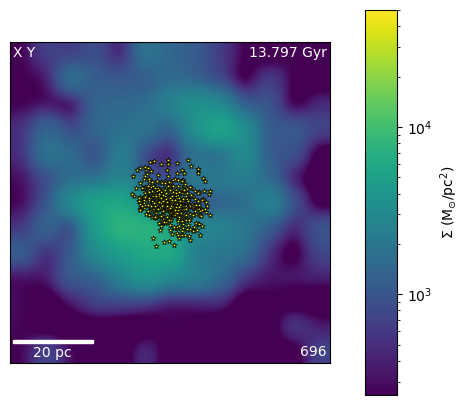

In [29]:
# Process the snapshots to get initial cluster information
cluster_select_solution = 0 #change this to any cluster as long as it is within range of the 'number of groups' value after running first_snapshot_data, 0 being the first cluster 
first_snapshot_data_solution = star_cluster_imaging.process_first_snapshot(gas_star_properties_data_solution[snaps_solution[0]],age_cut_Max_Myr=2, age_cut_Min_Myr=1, cluster_select = cluster_select_solution )

# Initialize variables
pc_width = 40 # this changes the zoom of the image. Based on this value the total width of the picture will be 2*pc_width
kpc_width = pc_width / 1e3
num_snapshots = len(snaps_solution)

plot_size = 5
fig = plt.figure(figsize=(num_snapshots*plot_size, plot_size))
gs0_solution = gridspec.GridSpec(1, num_snapshots+1, width_ratios= [1] * num_snapshots + [0.1])

gs_solution = gas_star_properties_data_solution[snapshot]
   
s_loc = star_cluster_imaging.preserve_ids(
    first_snapshot_data_solution['ids_cluster'],
    first_snapshot_data_solution['id_generation_cluster'],
    first_snapshot_data_solution['id_child_cluster'], 
    gs_solution['ids'], 
    gs_solution['id_generation'],
    gs_solution['id_child'])

vmin_value = 2.5e2  # Minimum value for the color bar 
vmax_value = 5e4    # Maximum value for the color bar

cluster_info = star_cluster_imaging.find_new_snap_info(s_loc, gs_solution)

mass_cluster = cluster_info['mass_cluster']
x_cluster = cluster_info['x_cluster']
y_cluster = cluster_info['y_cluster']
z_cluster = cluster_info['z_cluster']
    

xcm1 = first_snapshot_data_solution['sxcm'][cluster_select]
ycm1 = first_snapshot_data_solution['sycm'][cluster_select]
zcm1 = first_snapshot_data_solution['szcm'][cluster_select]


#creating filter that will only select the young stars that are visible in the picture
g_ind, s_ind = star_cluster_imaging.get_gas_star_indices(xcm1, ycm1, zcm1, gs_solution, pc_width=pc_width)
    
gas_star_coordinates = star_cluster_imaging.gas_star_coordinates(gs_solution, g_ind, x_cluster, y_cluster, z_cluster)

#Gaussian Smoothing for gas particles
vel_array_xy, res_xy, extent_xy = star_cluster_imaging.compute_velocity_array_xy(xcm1, ycm1, zcm1, gas_star_coordinates, pc_width=pc_width, stepn=13) # change the value of stepn to change the gas resolution
vel_array_xy = np.where(vel_array_xy < vmin_value, vmin_value, vel_array_xy) #This line is important for filling in any empty spaces in the gaussian smoothing. without it you end up with ugly white spaces when there is not gas in a region. 
ax = plt.subplot(gs0_solution[0])
ax.get_xaxis().set_visible(False) #remove x-axis labels
ax.get_yaxis().set_visible(False) #remove y-axis labels
ax.set_xlim(xcm1 - kpc_width, xcm1 + kpc_width) #keeping the image within kpc_width
ax.set_ylim(ycm1 - kpc_width, ycm1 + kpc_width) #keeping the image within kpc_width

#PLOT GAS 
ax.imshow(vel_array_xy.T / ((res_xy * 1000.) ** 2), interpolation='gaussian', norm=LogNorm(vmin=vmin_value, vmax=vmax_value), extent=extent_xy, origin='lower')

#PLOT STARS 
ax.scatter(x_cluster, y_cluster, s=15, marker='*', edgecolors='black', facecolors='yellow', linewidth=0.5) #This plots the stars, you can edit the colors and sizes to your liking

### Plain text
ax.text(0.01 ,0.99,'X Y', ha = 'left', va ='top', transform = ax.transAxes, c = 'white')
ax.text(0.99 ,0.01, snaps_solution[0], ha = 'right', va ='bottom', transform = ax.transAxes, c = 'white')

### Making Time Labels
snapshot_times = simdir + '/snapshot_times.txt' # Reading in the snapshot times from a text file to create titles for the images
snapnumber = snaps[0]  
# Reading the snapshot times and associated data from the text file
snaptime_data = np.genfromtxt(snapshot_times, usecols=(0, 3), skip_header=4, dtype=float)
snaps1 = np.array(snaptime_data[:, 0]) # Extracting the snapshot numbers (first column) from the data
times = np.array(snaptime_data[:, 1]) # Extracting the corresponding times (fourth column) from the data
snaptime = times[np.where(snaps1 == snapnumber)][0]# Finding the time associated with the current snapshot number
titles.append(f'XY VIEW {snaptime:.3f} Gyr')# Creating a title string that includes the snapshot time for the XY view
title = f'{snaptime:.3f}' + ' Gyr'# Creating a general title string for the snapshot time, formatted to 3 decimal places
ax.text(0.99 ,0.99,title, ha = 'right', va ='top', transform = ax.transAxes, c = 'white') #positioning and adding time label 


### Scalebar
scalebar_length = 20 #pc    
scalebar = AnchoredSizeBar(ax.transAxes, scalebar_length/(2*pc_width), f'{scalebar_length} pc', 'lower left', pad=0.1, color='white', frameon=False, size_vertical=.01)
ax.add_artist(scalebar)

### Colorbar
vmin_value = 2.5e2  # Minimum value for the color bar 
vmax_value = 5e4    # Maximum value for the color bar
axcb = plt.subplot(gs0_solution[num_snapshots])
cb = colorbar.ColorbarBase(axcb, norm=LogNorm(vmin=vmin_value, vmax=vmax_value))
cb.set_label('$\Sigma$ (M$_{\odot}$/pc$^2$)')

plt.show()

### Multiple Snapshots Examples:

***Below shows two examples for displaying multiple snapshots***

The first example produces the X Y view of the star cluster through time while the second example produces multiple viewpoints of the cluster per snapshot

They both use the setup for imaging a single snapshot but they are incorporated into a loop. You can try to edit some values to see what happens

In [4]:
snaps2 = [693,694,695]
# Initialize dictionaries to store properties
gas_star_properties_data = {}
part = {}
for snapshot in snaps2:
    # Read the snapshot data for the current snapshot
    part[snapshot] = gizmo.io.Read.read_snapshots(['star', 'gas'],'index', snapshot, simulation_directory=simdir, assign_hosts_rotation=True,assign_hosts=True)
    # Get star properties for the current snapshot
    gas_star_properties_data[snapshot] = star_cluster_imaging.get_gas_star_properties(part[snapshot])


# in utilities.simulation.Snapshot():
* reading:  scratch/07428/binod/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/snapshot_times.txt

  using snapshot index = 693, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/07428/binod/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/output/snapdir_693/snapshot_693.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 55620162 particles
    star      (id = 4): 15373067 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star', 'gas']
  gas properties: ['acceleration', 'density', 'electron.fraction', 'hydrogen.neutral.fraction', 'id', 'id.child', 'id.generation', 'magnetic.field', 'mass', 'massfraction', 'photon.energy', 'position', 'potential', 'sfr', 'size', 'temperature', 'velocity']

* reading particles from:
    snapshot_693.0.hdf5
    snapshot_6

In [5]:
# Process the snapshots to get initial cluster information
cluster_select = 0
first_snapshot_data = star_cluster_imaging.process_first_snapshot(gas_star_properties_data[snaps2[0]],age_cut_Max_Myr=2, age_cut_Min_Myr=0, cluster_select = cluster_select )

linking length  0.004
min number particles in group  5
0.057773590087890625 seconds
number of groups 9
max number in a group 16


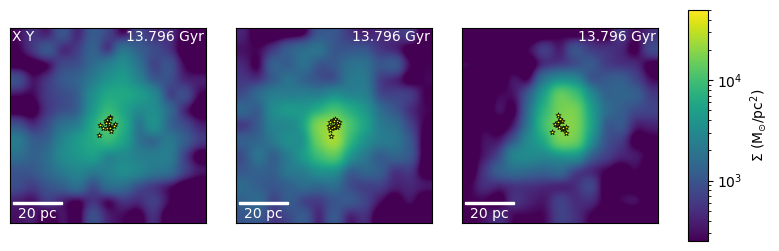

In [14]:
# Initialize variables
pc_width = 40
kpc_width = pc_width / 1e3
vmin_value = 2.5e2  # Minimum value for the color bar
vmax_value = 5e4    # Maximum value for the color bar
num_snapshots = len(snaps2)

# Create a list to store each snapshot's XY plane image data
xy_images = []
xz_images = []
yz_images = []
titles = []

# Plot all XY images together
#plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure(figsize=(num_snapshots*3, 3))
gs1 = gridspec.GridSpec(1, num_snapshots+1, width_ratios= [1] * num_snapshots + [0.1])

### Making Time Labels
snapshot_times = simdir + '/snapshot_times.txt' # Reading in the snapshot times from a text file to create titles for the images
snapnumber = snaps2[0]  
# Reading the snapshot times and associated data from the text file
snaptime_data = np.genfromtxt(snapshot_times, usecols=(0, 3), skip_header=4, dtype=float)
snaps1 = np.array(snaptime_data[:, 0]) # Extracting the snapshot numbers (first column) from the data
times = np.array(snaptime_data[:, 1]) # Extracting the corresponding times (fourth column) from the data
snaptime = times[np.where(snaps1 == snapnumber)][0]# Finding the time associated with the current snapshot number
titles.append(f'XY VIEW {snaptime:.3f} Gyr')# Creating a title string that includes the snapshot time for the XY view
title = f'{snaptime:.3f}' + ' Gyr'# Creating a general title string for the snapshot time, formatted to 3 decimal places

# Loop through snapshots to generate and store XY images
for index in range(num_snapshots):
    snapshot = snaps2[index]
    gs = gas_star_properties_data[snapshot]
   
    s_loc = star_cluster_imaging.preserve_ids(
        first_snapshot_data['ids_cluster'],
        first_snapshot_data['id_generation_cluster'],
        first_snapshot_data['id_child_cluster'], 
        gs['ids'], 
        gs['id_generation'],
        gs['id_child']
    )

    cluster_info = star_cluster_imaging.find_new_snap_info(s_loc, gs)

    mass_cluster = cluster_info['mass_cluster']
    x_cluster = cluster_info['x_cluster']
    y_cluster = cluster_info['y_cluster']
    z_cluster = cluster_info['z_cluster']
    
    if index == 0:
        xcm1 = first_snapshot_data['sxcm'][cluster_select]
        ycm1 = first_snapshot_data['sycm'][cluster_select]
        zcm1 = first_snapshot_data['szcm'][cluster_select]
    else:
        xcm1 = np.average(x_cluster, weights=mass_cluster)
        ycm1 = np.average(y_cluster, weights=mass_cluster)
        zcm1 = np.average(z_cluster, weights=mass_cluster)
        
    g_ind, s_ind = star_cluster_imaging.get_gas_star_indices(xcm1, ycm1, zcm1, gs, pc_width=pc_width)
    
    gas_star_coordinates = star_cluster_imaging.gas_star_coordinates(gs, g_ind, x_cluster, y_cluster, z_cluster)

    vel_array_xy, res_xy, extent_xy = star_cluster_imaging.compute_velocity_array_xy(xcm1, ycm1, zcm1, gas_star_coordinates, pc_width=pc_width, stepn=13)
    vel_array_xy = np.where(vel_array_xy < vmin_value, vmin_value, vel_array_xy)
    
    # Save the XY image data and extent for later plotting
    xy_images.append((vel_array_xy, extent_xy))
    
  
    ax = plt.subplot(gs1[index])
    vel_array_xy, extent_xy = xy_images[index]
    ax.imshow(vel_array_xy.T / ((res_xy * 1000.) ** 2), interpolation='gaussian', norm=LogNorm(vmin=vmin_value, vmax=vmax_value), extent=extent_xy, origin='lower')
    ax.scatter(x_cluster, y_cluster, s=15, marker='*', edgecolors='black', facecolors='yellow', linewidth=0.5)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xlim(xcm1 - kpc_width, xcm1 + kpc_width)
    ax.set_ylim(ycm1 - kpc_width, ycm1 + kpc_width)
    

    #Making Text
    
     # Reading in snapshot times to create titles
    snapshot_times = simdir + '/snapshot_times.txt'
    snapnumber = snaps2[index] # The particular snapshot we're looking at right now
    snaptime_data = np.genfromtxt(snapshot_times, usecols=(0, 3), skip_header=4, dtype=float)
    snaps1 = np.array(snaptime_data[:, 0])
    times = np.array(snaptime_data[:, 1])
    snaptime = times[np.where(snaps1 == snapnumber)][0]
    titles.append(f'XY VIEW {snaptime:.3f} Gyr')
    
    ax.text(0.99 ,0.99,title, ha = 'right', va ='top', transform = ax.transAxes, c = 'white')
    if index == 0:
        ax.text(0.01 ,0.99,'X Y', ha = 'left', va ='top', transform = ax.transAxes, c = 'white')
    #ax.set_title(titles[index])
    scalebar_length = 20 #pc
    
    scalebar = AnchoredSizeBar(ax.transAxes, scalebar_length/(2*pc_width), f'{scalebar_length} pc', 'lower left', pad=0.1, color='white', frameon=False, size_vertical=.01)
    ax.add_artist(scalebar)
    
    # Create the colorbar subplot in the last grid cell
    axcb = plt.subplot(gs1[num_snapshots])
    cb = colorbar.ColorbarBase(axcb, norm=LogNorm(vmin=vmin_value, vmax=vmax_value))
    cb.set_label('$\Sigma$ (M$_{\odot}$/pc$^2$)')
    
plt.show()

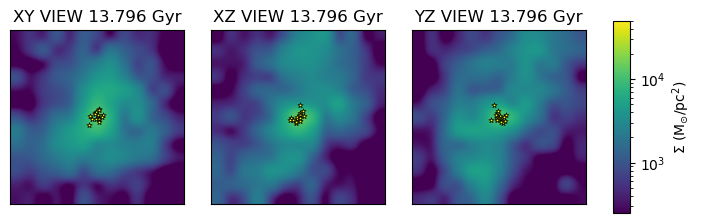

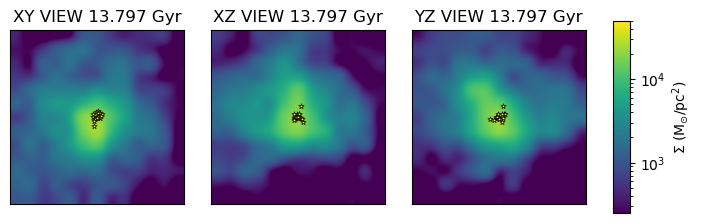

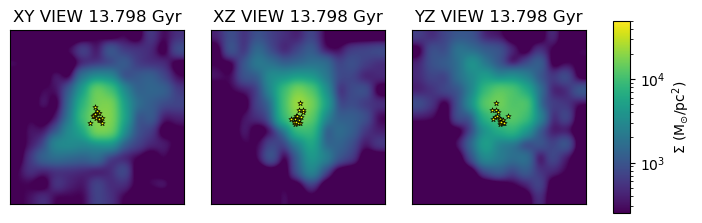

In [16]:
#NOTE: was unable to get the text onto the plots themselves using ax.text.

pc_width = 40
kpc_width = pc_width/1e3
# Set the desired color bar limits
vmin_value = 2.5e2  # Minimum value for the color bar
#vmin_value = 1
vmax_value = 5e4  # Maximum value for the color bar

for index in range(len(snaps2)):
    snapshot = snaps2[index]
    gs = gas_star_properties_data[snapshot]
  
    s_loc = star_cluster_imaging.preserve_ids(
        first_snapshot_data['ids_cluster'],
        first_snapshot_data['id_generation_cluster'],
        first_snapshot_data['id_child_cluster'], 
        gs['ids'], 
        gs['id_generation'],
        gs['id_child']
    )

    cluster_info = star_cluster_imaging.find_new_snap_info(s_loc, gs)

    mass_cluster = cluster_info['mass_cluster']
    x_cluster = cluster_info['x_cluster']
    y_cluster = cluster_info['y_cluster']
    z_cluster = cluster_info['z_cluster']
    
    if index == 0:
        # Use the initial xcm1, ycm1, zcm1 for the first snapshot
        xcm1 = first_snapshot_data['sxcm'][cluster_select]
        ycm1 = first_snapshot_data['sycm'][cluster_select]
        zcm1 = first_snapshot_data['szcm'][cluster_select]
    else:
        # Update xcm1, ycm1, zcm1 for subsequent snapshots
        xcm1 = np.average(x_cluster, weights=mass_cluster)
        ycm1 = np.average(y_cluster, weights=mass_cluster)
        zcm1 = np.average(z_cluster, weights=mass_cluster)
        

    g_ind, s_ind = star_cluster_imaging.get_gas_star_indices(xcm1, ycm1, zcm1, gs, pc_width=pc_width)
    
    
    gas_star_coordinates = star_cluster_imaging.gas_star_coordinates(gs, g_ind, x_cluster, y_cluster, z_cluster)

    vel_array_xy, res_xy, extent_xy = star_cluster_imaging.compute_velocity_array_xy(xcm1, ycm1, zcm1, gas_star_coordinates, pc_width=pc_width, stepn=13)
    vel_array_xz, res_xz, extent_xz = star_cluster_imaging.compute_velocity_array_xz(xcm1, ycm1, zcm1, gas_star_coordinates, pc_width=pc_width, stepn=13)
    vel_array_yz, res_yz, extent_yz = star_cluster_imaging.compute_velocity_array_yz(xcm1, ycm1, zcm1, gas_star_coordinates, pc_width=pc_width, stepn=13)

    vel_array_xy= np.where(vel_array_xy < vmin_value, vmin_value, vel_array_xy)
    vel_array_xz= np.where(vel_array_xz < vmin_value, vmin_value, vel_array_xz)
    vel_array_yz= np.where(vel_array_yz < vmin_value, vmin_value, vel_array_yz)
    
    #PLOTTING IMAGES
    # Create a new figure for each snapshot
    fig = plt.figure(figsize=(8, 2.5))
    #gs0 = gridspec.GridSpec(1, 2, width_ratios=[1, 0.1])
    gs0 = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.1])
    ax0 = plt.subplot(gs0[0])
    ax1 = plt.subplot(gs0[1])
    ax2 = plt.subplot(gs0[2])
    axcb = plt.subplot(gs0[3])

    # Create the LogNorm object with the desired limits
    norm1 = LogNorm(vmin=vmin_value, vmax=vmax_value)

    # Use the same norm1 object in the ColorbarBase function
    cb = colorbar.ColorbarBase(axcb, norm=norm1)
    cb.set_label('$\Sigma$ (M$_{\odot}$/pc$^2$)')
    
    # Use the norm1 object in the imshow function
    
    
    #ax0.scatter(gas_star_coordinates['g_xs'],gas_star_coordinates['g_ys'],edgecolors='red', facecolors='red', s = 10) #uncomment to show exact gas positions
    
    # Plot the stars
    
    ax0.imshow(vel_array_xy.T / ((res_xy * 1000.) ** 2), interpolation='gaussian', norm=norm1, extent=extent_xy, origin='lower')
    #ax0.scatter(gs['x'],gs['y'], s=15, marker='*',  edgecolors='black', facecolors='yellow', linewidth=0.5) #All nearby stars without filter
    ax0.scatter(x_cluster, y_cluster, s=15, marker='*', edgecolors='black', facecolors='yellow', linewidth=0.5)
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)
    ax0.set_xlim(xcm1 - kpc_width, xcm1 + kpc_width)
    ax0.set_ylim(ycm1 - kpc_width, ycm1 + kpc_width)
    
    

    ax1.imshow(vel_array_xz.T / ((res_xz * 1000.) ** 2), interpolation='gaussian', norm=norm1, extent=extent_xz, origin='lower')
    ax1.scatter(x_cluster, z_cluster, s=15, marker='*', edgecolors='black', facecolors='yellow', linewidth=0.5)
    #ax1.scatter(gs['x'],gs['z'], s=15, marker='*',  edgecolors='black', facecolors='yellow', linewidth=0.5) #All nearby stars without filter
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_xlim(xcm1 - kpc_width, xcm1 + kpc_width)
    ax1.set_ylim(zcm1 - kpc_width, zcm1 + kpc_width)
    

    ax2.imshow(vel_array_yz.T / ((res_yz * 1000.) ** 2), interpolation='gaussian', norm=norm1, extent=extent_yz, origin='lower')
    ax2.scatter(y_cluster, z_cluster, s=15, marker='*', edgecolors='black', facecolors='yellow', linewidth=0.5)
    #ax2.scatter(gs['y'],gs['z'], s=15, marker='*',  edgecolors='black', facecolors='yellow', linewidth=0.5) #All nearby stars without filter
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_xlim(ycm1 - kpc_width, ycm1 + kpc_width)
    ax2.set_ylim(zcm1 - kpc_width, zcm1 + kpc_width)
   
    #reading in snapshot_times.txt file to get snapshot numbers and times
    # columns are: snapshot scale-factor redshift time[Gyr] time_width[Myr]
    snapshot_times = simdir +'/snapshot_times.txt'
    snapnumber = snaps2[index] #the particular snapshot we're looking at right now

    snaptime_data = np.genfromtxt(snapshot_times, usecols=(0,3), skip_header=4, dtype=float) #the first and fourth columns are the only ones we need 
    snaps1 = np.array(snaptime_data[:,0]) #col1 = first column saved from text file
    times = np.array(snaptime_data[:,1]) #col4 = second column saved

    snaptime = times[np.where(snaps1 == snapnumber)][0] #time of snapshot in Gyr
    #print(f'{snaptime:.3f}') #this format saves 3 places after the decimal
    title = f'{snaptime:.3f}' + ' Gyr'
    ax0.set_title(f'XY VIEW {title}')
    ax1.set_title(f'XZ VIEW {title}')
    ax2.set_title(f'YZ VIEW {title}')
    #plt.savefig(f'andrew_gmc_cluster_{snapshot}.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)
